In [1]:
from models.transforms import get_object_transforms
from models.data import EvalStoryDataset
from models.model import StoryModel
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer
from accelerate.utils import set_seed
from models.utils import parse_args
from accelerate import Accelerator
from pathlib import Path
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import os
from tqdm.auto import tqdm
from models.pipeline import (
    stable_diffusion_call_with_references_delayed_conditioning,
)
import types
import itertools
import os
import pickle
import random
import matplotlib.pyplot as plt

from gill import models
from gill import utils


/home/shenx/.conda/envs/story/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RES=512
inference_steps=30
OUTPUT_DIR="test"
args = parse_args(["--no_object_augmentation"])

finetuned_model_path="FIRST_STAGE_MODEL_FOLDER"
gill_ckpt="SECOND_STAGE_MODEL_FOLDER"

args.finetuned_model_path=finetuned_model_path
args.output_dir=OUTPUT_DIR
args.mixed_precision='fp16'
args.inference_steps=30
args.start_merge_step=10
args.ref_image="same"
args.gill_ckpt=gill_ckpt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
accelerator = Accelerator(
    mixed_precision=args.mixed_precision,
)

# Handle the repository creation
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)
accelerator.wait_for_everyone()

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

weight_dtype = torch.float16

pipe = StableDiffusionPipeline.from_pretrained(
    args.pretrained_model_name_or_path, torch_dtype=weight_dtype
)
pipe.set_progress_bar_config(disable=True)
pipe.safety_checker = None
pipe.requires_safety_checker = False

model = StoryModel.from_pretrained(args)

ckpt_name = "pytorch_model.bin"

model.load_state_dict(
    torch.load(Path(args.finetuned_model_path) / ckpt_name, map_location="cpu"), strict=False
)

model = model.to(device=accelerator.device, dtype=weight_dtype)

model_dir = args.gill_ckpt
mm_llm = models.load_gill(model_dir)
g_cuda = torch.Generator(device='cuda').manual_seed(1337)

pipe.unet = model.unet

if args.enable_xformers_memory_efficient_attention:
    pipe.unet.enable_xformers_memory_efficient_attention()

pipe.text_encoder = model.text_encoder
pipe.image_encoder = model.image_encoder

pipe.postfuse_module = model.postfuse_module

pipe.inference = types.MethodType(
    stable_diffusion_call_with_references_delayed_conditioning, pipe
)

del model

pipe = pipe.to(accelerator.device)

# Set up the dataset
tokenizer = CLIPTokenizer.from_pretrained(
    args.pretrained_model_name_or_path,
    subfolder="tokenizer",
    revision=args.revision,
)

object_transforms = get_object_transforms(args)

unique_token = "<|image|>"

import json

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_tok

Using HuggingFace AutoFeatureExtractor for openai/clip-vit-large-patch14.
Using /home/shenx/projects/.checkpoints/minigpt4_v2/llama-2-7b-chat-pytorch for the language model.
Using openai/clip-vit-large-patch14 for the visual model with 4 visual tokens.


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.06s/it]


Freezing the LM.
Restoring pretrained weights for the visual model.
Freezing the VM.


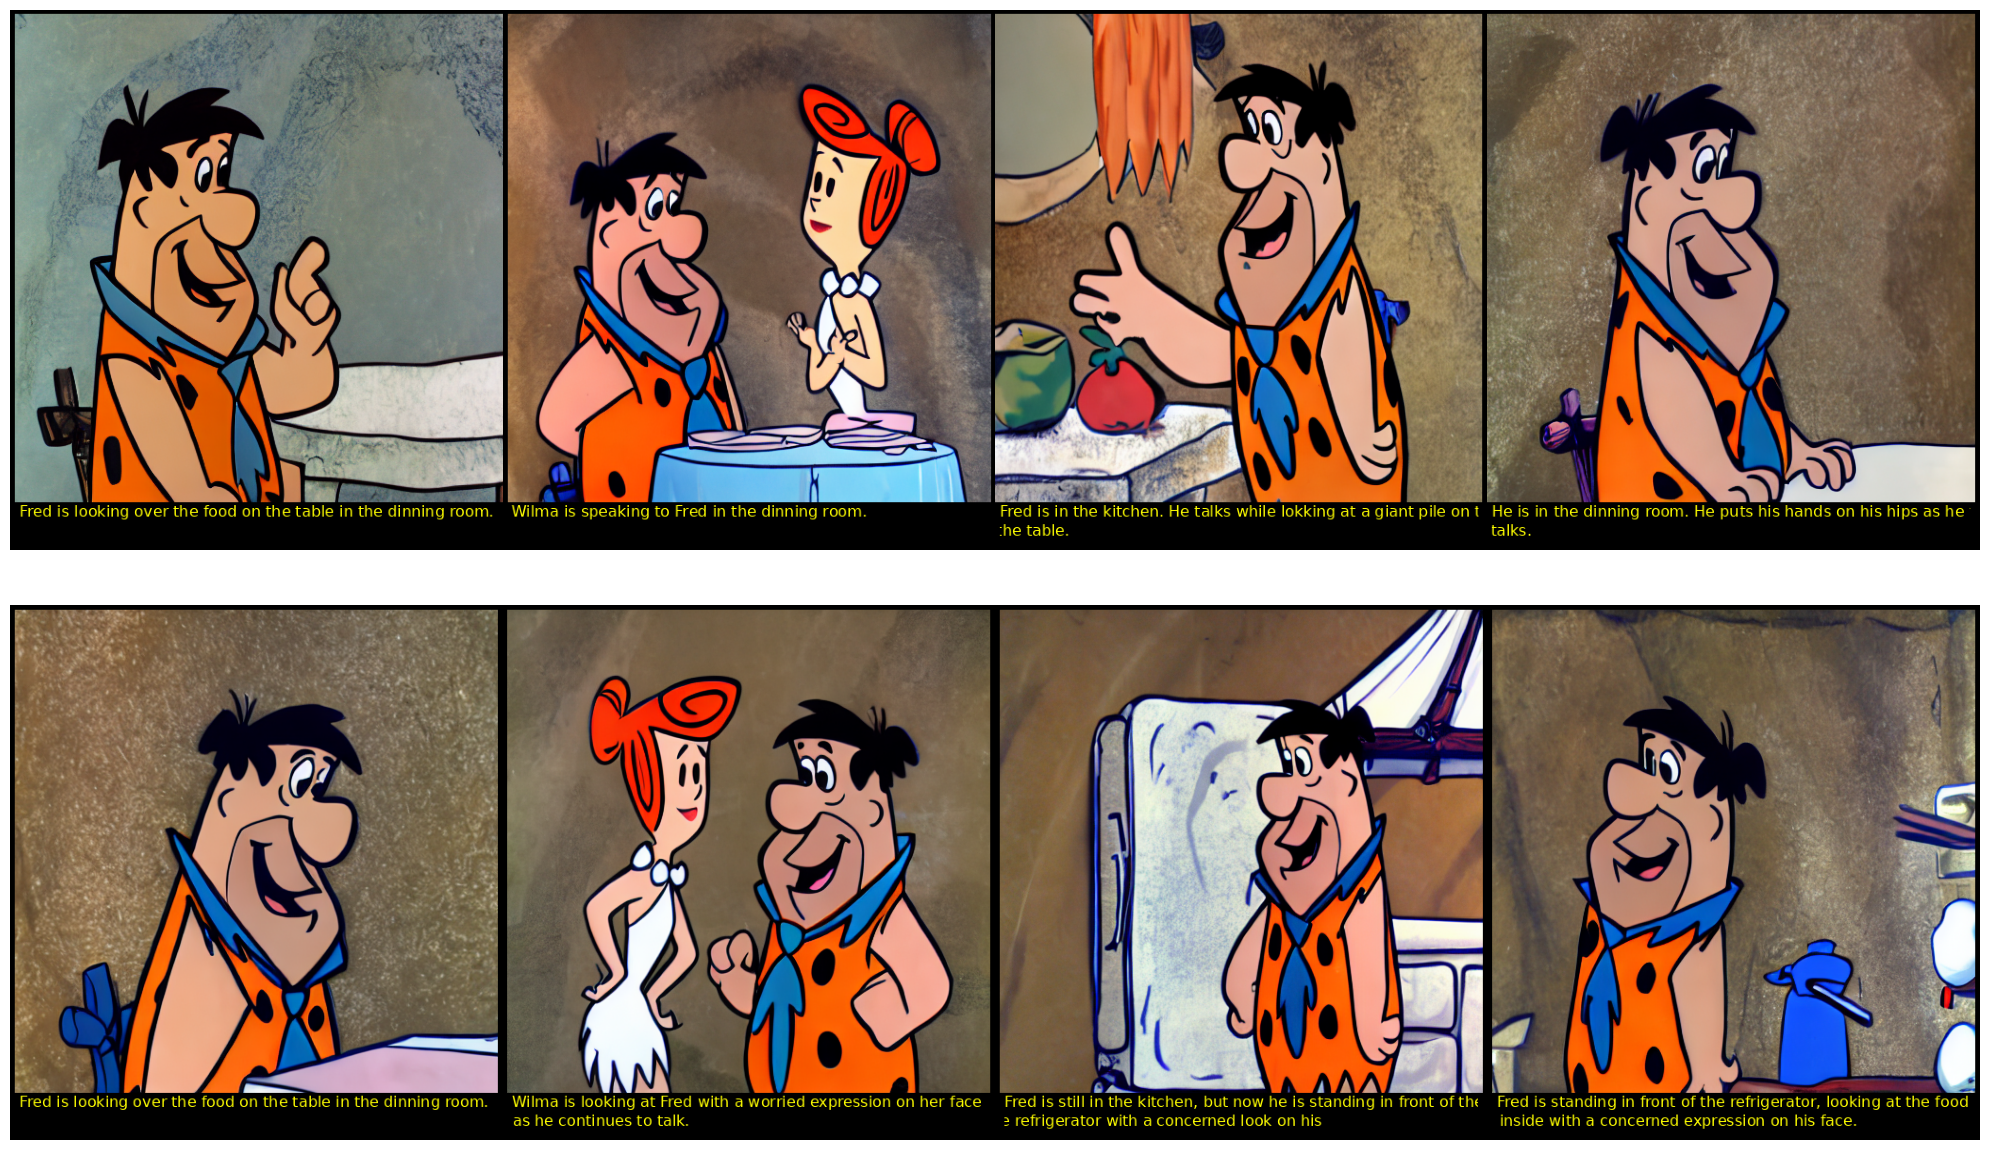

In [27]:
captions = ['Fred is looking over the food on the table in the dinning room.',
            'Wilma is speaking to Fred in the dinning room.',
            'Fred is in the kitchen. He talks while lokking at a giant pile on the table.',
            'He is in the dinning room. He puts his hands on his hips as he talks.']

fig, (axes1, axes2) = plt.subplots(2, 1, figsize=(20,12))
gen_images = []
gen_captions = captions
image_cap_gt = []
image_cap_gen = []
with torch.no_grad():
    for idx, caption in enumerate(captions):
        prompt_llm = []
        if idx == 0:
            prompt_llm.append('Caption: ' + captions[idx] + ' Image: ')
        else:
            for i in range(idx+1):
                if i == idx:
                    prompt_llm.append(' Caption: ' + captions[i] + ' Image: ')
                else:
                    prompt_llm.append(' Image: <img>')
                    prompt_llm.append(gen_images[i])
                    prompt_llm.append('</img> Caption: ' + captions[i])
 
        encoder_hidden_states, _ = mm_llm.generate_for_images_emb(prompt_llm, num_words=2, generator=g_cuda)
        encoder_hidden_states = encoder_hidden_states.cuda()
        args.start_merge_step = 0

        encoder_hidden_states_text_only = pipe._encode_prompt(
            captions[idx],
            accelerator.device,
            args.num_images_per_prompt,
            do_classifier_free_guidance=False,
        )

        cross_attention_kwargs = {}

        images = pipe.inference(
            prompt_embeds=encoder_hidden_states,
            num_inference_steps=args.inference_steps,
            height=args.generate_height,
            width=args.generate_width,
            guidance_scale=args.guidance_scale,
            num_images_per_prompt=args.num_images_per_prompt,
            cross_attention_kwargs=cross_attention_kwargs,
            prompt_embeds_text_only=encoder_hidden_states_text_only,
            start_merge_step=args.start_merge_step,
        ).images
        
        gen_images.append(images[0])
        border_size = 5

        cap_img = utils.create_image_of_text(captions[idx], width=args.generate_width, nrows=2, color=(255, 255, 0))
        image = transforms.ToTensor()(images[0])
        image_tensor = torch.cat([image, cap_img], dim=1)
        new_height = image_tensor.shape[1] + 2 * border_size
        new_width = image_tensor.shape[2] + 2 * border_size
        border_canvas = torch.zeros(3, new_height, new_width)
        border_canvas[:, border_size:border_size + image_tensor.shape[1], border_size:border_size + image_tensor.shape[2]] = image_tensor
        if idx == 1:
            border_canvas = border_canvas[:, :, border_size+1:border_size-4 + image_tensor.shape[2]]
        if idx == 2:
            border_canvas = border_canvas[:, :, border_size-4:border_size-1 + image_tensor.shape[2]]
        image_cap_gen.append(border_canvas)
        
    image_cap_gen = torch.cat(image_cap_gen, dim=-1)
    image_cap_gen = transforms.ToPILImage()(image_cap_gen)
    
with torch.no_grad():
    image_cap_gen_extend = []
    max_length = 8
    gen_caption_flag = True
    while len(gen_images) < max_length:
        prompt_llm = []
        if gen_caption_flag:
            for i in range(len(gen_captions) - 4, len(gen_captions)):
                prompt_llm.append('Caption: ' + gen_captions[i])
            prompt_llm.append(f' Generate the next frame description of cartoon Flintstones based on the previous captions. The new generation should be different from the previous captions.')
        else:
            for i in range(len(gen_images) - 4, len(gen_images)):
                prompt_llm.append(' Image: <img>')
                prompt_llm.append(gen_images[i])
                prompt_llm.append('</img> Caption: ' + gen_captions[i])
            prompt_llm.append(f' Caption: {gen_captions[-1]} Image: ')
        
        if gen_caption_flag:
            encoder_hidden_states, caption = mm_llm.generate_for_images_emb(prompt_llm, num_words=36, min_word_tokens=30)
            caption = caption.replace('\n', '')
            index = caption.find("[IMG")
            if index != -1:
                caption = caption[:index]
            index = caption.find(".")
            if index != -1:
                caption = caption[:index+1]
            index = caption.find(":")
            if index != -1:
                caption = caption[index+1:]
            caption = caption.strip()
            gen_captions.append(caption)
            gen_caption_flag = False
        else:
            encoder_hidden_states, caption = mm_llm.generate_for_images_emb(prompt_llm, num_words=2)
            encoder_hidden_states = encoder_hidden_states.half()
            images = pipe.inference(
                prompt_embeds=encoder_hidden_states,
                num_inference_steps=args.inference_steps,
                height=args.generate_height,
                width=args.generate_width,
                guidance_scale=args.guidance_scale,
                num_images_per_prompt=args.num_images_per_prompt,
                cross_attention_kwargs=cross_attention_kwargs,
                prompt_embeds_text_only=encoder_hidden_states,
                start_merge_step=0,
            ).images
            gen_images.append(images[0])
            gen_caption_flag = True
            cap_img = utils.create_image_of_text(gen_captions[-1], width=args.generate_width, nrows=2, color=(255, 255, 0))
            image = transforms.ToTensor()(images[0])
            image_tensor = torch.cat([image, cap_img], dim=1)
            new_height = image_tensor.shape[1] + 2 * border_size
            new_width = image_tensor.shape[2] + 2 * border_size
            border_canvas = torch.zeros(3, new_height, new_width)
            border_canvas[:, border_size:border_size + image_tensor.shape[1], border_size:border_size + image_tensor.shape[2]] = image_tensor
            if idx == 1:
                border_canvas = border_canvas[:, :, border_size+1:border_size-4 + image_tensor.shape[2]]
            if idx == 2:
                border_canvas = border_canvas[:, :, border_size-4:border_size-1 + image_tensor.shape[2]]
            image_cap_gen_extend.append(border_canvas)
    image_cap_gen_extend = torch.cat(image_cap_gen_extend, dim=-1)
    image_cap_gen_extend = transforms.ToPILImage()(image_cap_gen_extend)
    axes1.imshow(image_cap_gen)
    axes1.axis('off')
    axes2.imshow(image_cap_gen_extend)
    axes2.axis('off')
plt.tight_layout()
plt.show()